训练集标注可视化

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import cv2
import os
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from glob import glob
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm
from Polygon import Polygon



# 按行生成彩色标注框
idx2color = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            idx2color.append((i*100, j*100, k*100))
idx2color.append((255, 0, 0))
idx2color = np.array(idx2color)


def table_visualize(img_name, src_img, table, key='row', only_last=False):
    last_img = src_img.copy()
    for idx, row in enumerate(table[key]):
        color = idx2color[idx % len(idx2color)]
        pts = np.array(row, dtype=np.int32)
        if not only_last:
            temp_img = src_img.copy()
            cv2.polylines(temp_img, [pts], True, color.tolist(), 1)
        cv2.polylines(last_img, [pts], True, color.tolist(), 1)
        
        cx, cy = pts.mean(axis=0)
        if not only_last:
            cv2.putText(temp_img, str(idx), (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
            plt.title(f"{img_name}: {key}")
            plt.imshow(temp_img)
            plt.show()
        cv2.putText(last_img, str(idx), (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)
        last_img = cv2.cvtColor(last_img, cv2.COLOR_BGR2RGB)
    plt.title(f"{img_name}: {key}")
    plt.imshow(last_img)
    plt.show()

def label_visualize(img_name, src_img, label):
    for cell in label['cells']:
        start_row_idx = cell['row_start_idx']
        end_row_idx   = cell['row_end_idx']
        start_col_idx = cell['col_start_idx']
        end_col_idx   = cell['col_end_idx']
        color = idx2color[start_row_idx % len(idx2color)]
        x0, y0, x1, y1 = cell['bbox']

        pts = np.array(cell['segmentation'], dtype=np.int32)
        cv2.rectangle(src_img, (int(x0), int(y0)), (int(x1), int(y1)), color.tolist(), 1)

        theight = cv2.getTextSize(str(start_row_idx), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0][1]
        show_text = f"{start_row_idx}" if start_row_idx == end_row_idx else f"{start_row_idx}-{end_row_idx}"
        show_text += f",{start_col_idx}" if start_col_idx == end_col_idx else f" {start_col_idx}-{end_col_idx}"

        cv2.putText(src_img, show_text, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        # transcript = cell['transcript']
        # cv2.putText(src_img, transcript, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        plt.title(img_name)
        plt.imshow(src_img)
    plt.show()

def rotate_label_visualize(img_name, src_img, label):
    h, w = src_img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, -1, 1.0)
    src_img = cv2.warpAffine(src_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # src_img = cv2.warpAffine(src_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

    for cell in label['cells']:
        start_row_idx = cell['row_start_idx']
        end_row_idx   = cell['row_end_idx']
        start_col_idx = cell['col_start_idx']
        end_col_idx   = cell['col_end_idx']
        color = idx2color[start_row_idx % len(idx2color)]
        x0, y0, x1, y1 = cell['bbox']
        print(1, type(cv2.transform(np.array([[[x0, y0], [x1, y1]]]), M)))
        print(2, type(cv2.transform(np.array([[[x0, y0], [x1, y1]]]), M).squeeze()))
        [x0, y0], [x1, y1] = cv2.transform(np.array([[[x0, y0], [x1, y1]]]), M).squeeze().astype(np.int32)

        pts = np.array(cell['segmentation'], dtype=np.int32)
        cv2.rectangle(src_img, (int(x0), int(y0)), (int(x1), int(y1)), color.tolist(), 1)

        theight = cv2.getTextSize(str(start_row_idx), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0][1]
        show_text = f"{start_row_idx}" if start_row_idx == end_row_idx else f"{start_row_idx}-{end_row_idx}"
        show_text += f",{start_col_idx}" if start_col_idx == end_col_idx else f" {start_col_idx}-{end_col_idx}"

        cv2.putText(src_img, show_text, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        plt.title(img_name)
        plt.imshow(src_img)
    plt.show()





In [3]:
def sort_sementations(rows, cols):
    # sort rows from top to down
    row_locs = []
    for row_seg in rows:
        points_ = np.vstack([itm for itm in row_seg])
        row_loc_ = np.mean(points_, axis=0)[1]
        row_locs.append(row_loc_)
    row_index = np.argsort(row_locs)
    rows = [rows[idx_] for idx_ in row_index]

    # sort cols from left to right
    col_locs = []
    for col_seg in cols:
        points_ = np.vstack([itm for itm in col_seg])
        col_loc_ = np.mean(points_, axis=0)[0]
        col_locs.append(col_loc_)
    col_index = np.argsort(col_locs)
    cols = [cols[idx_] for idx_ in col_index]

    return rows, cols


def boundingbox_crop(img_array, rc_label):
    pts = []
    if rc_label['is_wireless']:
        for line in rc_label['line']:
            pts.extend(line)
    else:
        for cell in rc_label['cell']:
            pts.extend(cell)
    pts = np.array(pts, dtype=np.int32)
    gap = 10
    x0, y0, x1, y1 = int(pts[:, 0].min()), int(pts[:, 1].min()), int(pts[:, 0].max()), int(pts[:, 1].max())
    x0 = max(0, x0-gap)
    y0 = max(0, y0-gap)
    x1 = min(img_array.shape[1], x1+gap)
    y1 = min(img_array.shape[0], y1+gap)
    img_array = img_array[y0:y1, x0:x1]

    for idx, row in enumerate(rc_label['row']):
        row = np.array(row)
        row[:, 0] -= x0
        row[:, 1] -= y0
        rc_label['row'][idx] = row.tolist()
    for idx, col in enumerate(rc_label['col']):
        col = np.array(col)
        col[:, 0] -= x0
        col[:, 1] -= y0
        rc_label['col'][idx] = col.tolist()
    for idx, line in enumerate(rc_label['line']):
        line = np.array(line)
        line[:, 0] -= x0
        line[:, 1] -= y0
        rc_label['line'][idx] = line.tolist()
    for idx, cell in enumerate(rc_label['cell']):
        cell = np.array(cell)
        cell[:, 0] -= x0
        cell[:, 1] -= y0
        rc_label['cell'][idx] = cell.tolist()

    return img_array, rc_label

def remove_overlay_line(seg, lines, iou_threshold=0.5):
    new_line = []
    rc_poly = Polygon(seg)
    for i in range(len(lines)):
        line_poly = Polygon(lines[i])
        iou = (rc_poly & line_poly).area() / line_poly.area()
        if iou > iou_threshold:
            continue
        new_line.append(lines[i])
    return new_line



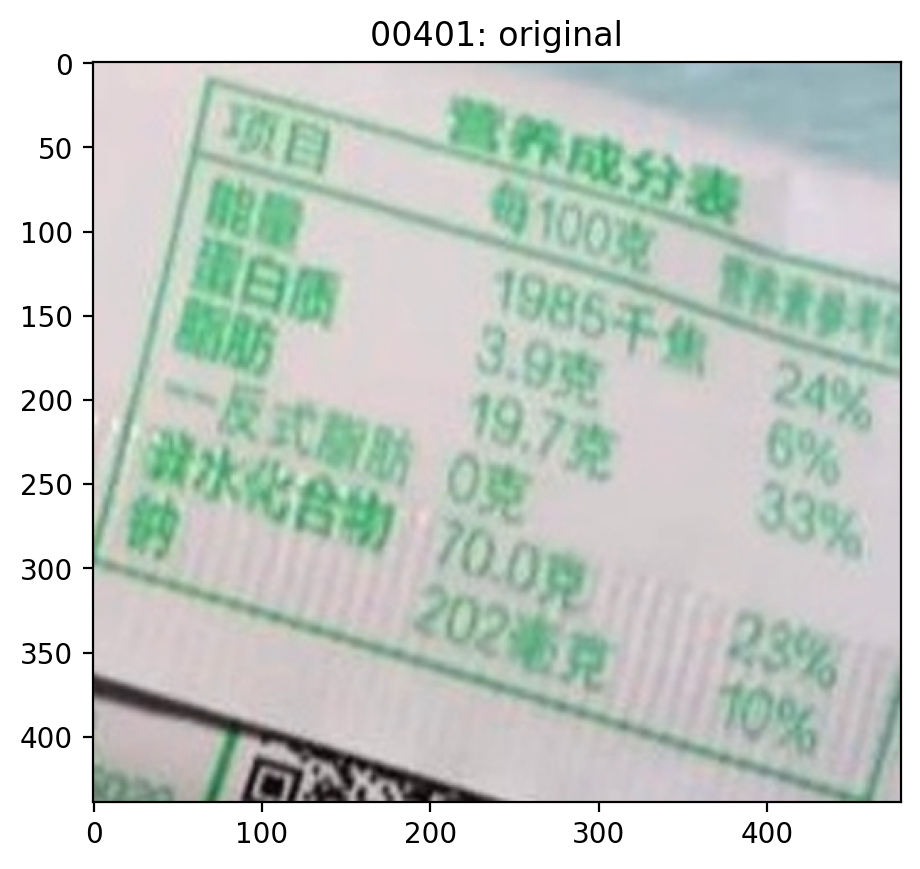

remove col 1


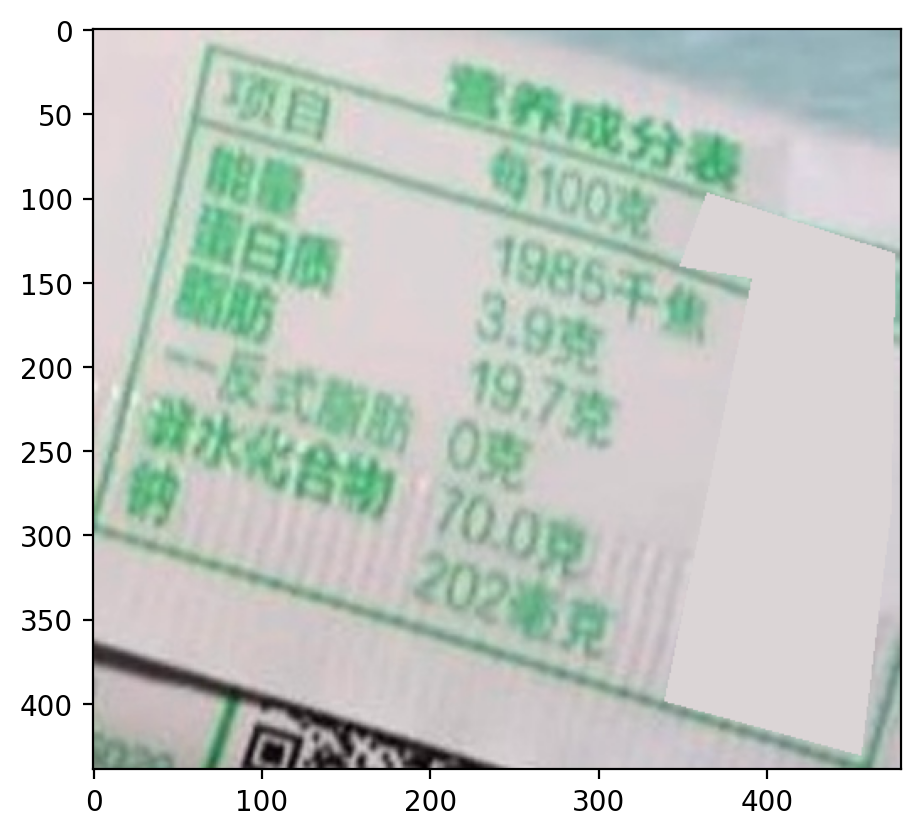

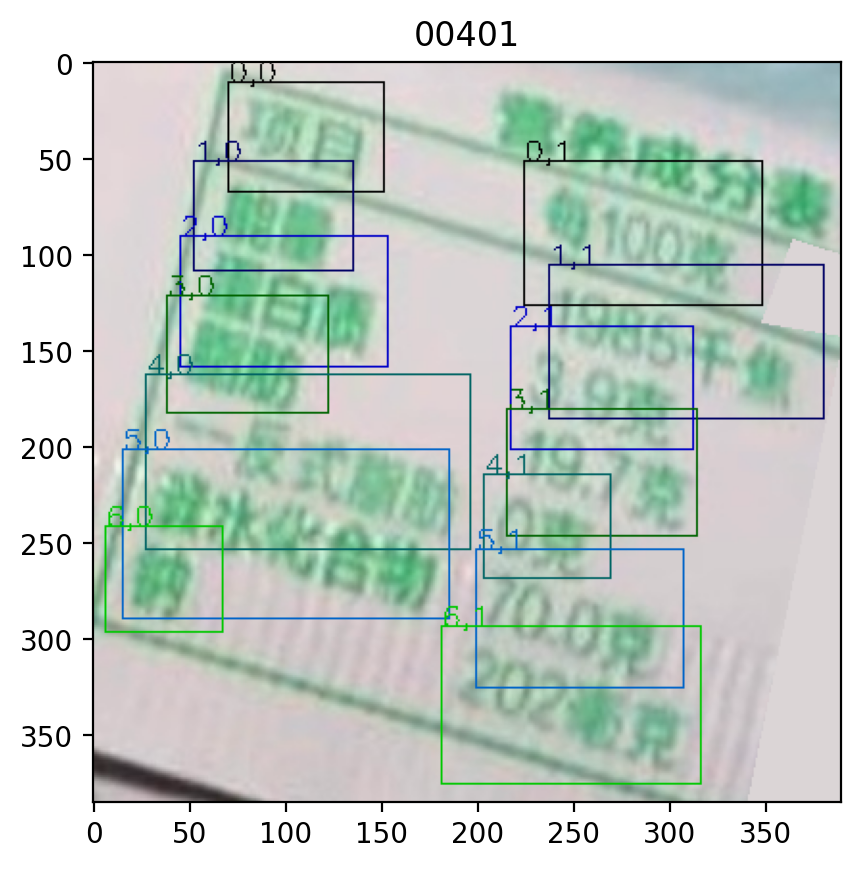

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]]
7 2
7 3


In [4]:
import utils.table2label as table2label
import random
from utils.format_translate import segmentation_to_bbox

'''
可视化单一图像
'''
# img_id = '00414'
img_id = '00401'
jpg_path  = f"/media/ubuntu/Date12/TableStruct/new_data/train_jpg480max/{img_id}.jpg"
json_path = f"/media/ubuntu/Date12/TableStruct/new_data/train_jpg480max/{img_id}.json"

img_array = cv2.imread(jpg_path)
plt.title(f"{img_id}: original")
plt.imshow(img_array)
plt.show()

rc_label = json.load(open(json_path, 'r'))
rc_label['row'], rc_label['col'] = sort_sementations(rc_label['row'], rc_label['col'])

ori_img_array = img_array.copy()
ori_rc_label = rc_label.copy()
ori_struct_label = table2label.table2label(ori_rc_label)   

# table_visualize(img_id, img_array, rc_label, 'line', only_last=True)

unique_values, value_counts = np.unique(img_array.reshape(-1, img_array.shape[-1]), axis=0, return_counts=True)
bg_color = unique_values[np.argmax(value_counts)]


ratio = 0.5

if random.random() < 0.5:
    print("remove row")
    top_cnt = 0
    bottom_cnt = random.randint(0, int(len(rc_label['row'])*ratio))
    bottom_cnt = 1
    new_row = []
    for i in range(len(rc_label['row'])):
        if i < top_cnt or i >= len(rc_label['row']) - bottom_cnt:
            row_seg = rc_label['row'][i]
            cv2.fillPoly(img_array, np.array([row_seg], dtype=np.int32), color=bg_color.tolist())
            rc_label['line'] = remove_overlay_line(row_seg, rc_label['line'])
            rc_label['cell'] = remove_overlay_line(row_seg, rc_label['cell'])
        else:
            new_row.append(rc_label['row'][i])
    rc_label['row'] = new_row
else:
    left_cnt = 0
    right_cnt = random.randint(0, int(len(rc_label['col'])*ratio))
    right_cnt = 1
    print("remove col", right_cnt)
    new_col = []
    for i in range(len(rc_label['col'])):
        if i < left_cnt or i >= len(rc_label['col']) - right_cnt:
            col_seg = rc_label['col'][i]
            cv2.fillPoly(img_array, np.array([col_seg], dtype=np.int32), color=bg_color.tolist())
            rc_label['line'] = remove_overlay_line(col_seg, rc_label['line'])
            rc_label['cell'] = remove_overlay_line(col_seg, rc_label['cell'])
        else:
            new_col.append(rc_label['col'][i])
    rc_label['col'] = new_col

plt.imshow(img_array)
plt.show()

img_array, rc_label = boundingbox_crop(img_array, rc_label)

# mode = np.unique(src_img, return_counts=True)[0][np.argmax(np.unique(src_img, return_counts=True)[1])]

# if not table2label.table_valid(table):
#     print("table_valid error!", img_id)
# # table = table2label.fix_table_error(table)

# table_visualize(img_id, img_array, rc_label, 'row', only_last=True)
# table_visualize(img_id, img_array, rc_label, 'col', only_last=True)
# table_visualize(img_id, img_array, rc_label, 'line', only_last=True)
# table_visualize(img_id, img_array, rc_label, 'cell', only_last=True)
layout = table2label.table2layout(rc_label)
struct_label = table2label.table2label(rc_label)
label_visualize(img_id, img_array, struct_label)
print(np.array(struct_label['layout']))
n_row, n_col = np.array(struct_label['layout']).shape
print(n_row, n_col)
ori_n_row, ori_n_col = np.array(ori_struct_label['layout']).shape
print(ori_n_row, ori_n_col)

valid, msg = table2label.judge_error(rc_label, struct_label)
if not valid:
    print(msg)

